In [57]:
import pandas as pd
import os
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot  as plt
import datetime
import copy

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, auc, silhouette_score

from tslearn.metrics import dtw, soft_dtw
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

from minepy import MINE  
from math import exp, sqrt, floor

import tensorflow as tf
import tqdm.notebook as tq
from tqdm.notebook import tqdm
import gc
import psutil
import logging
import seaborn as sns; sns.set()  # for plot styling


tf.get_logger().setLevel(logging.ERROR)

psutil.virtual_memory()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# data acquisition and pre-processing

## data acquisition

In [2]:
def get_file_from_folder(path):
    data = {}
    data_path = path
    headers = ["MeterID", "Datetime", "Electricity"]

    for file_name in os.listdir(data_path):
        file_path = os.path.join(data_path, file_name)

        df = pd.read_csv(file_path, sep=" ", names=headers)
        data[file_name] = df

    return data

def transform_daycode_to_date(days_int):
    days = int(str(days_int)[:3])
    add_date = datetime.timedelta(days=days)
    current_date = START_DATE + add_date
    return str(current_date)

def transform_dataframe(df):
    df = df.sort_values(by = ['MeterID', 'Datetime'])

    df["Day"] = df["Datetime"].map(lambda x: transform_daycode_to_date(x))
    df["Time"] = df["Datetime"].map(lambda x: str(x)[3:])
    df["Time"] = pd.to_numeric(df["Time"], downcast='integer')

    df = df[['MeterID','Day', 'Time', 'Electricity', 'Datetime']]
    return df

def print_df_summary(df, all=False):
    print(f"MeterID count : {df.value_counts('MeterID').unique()}")
    print(f"Datetime count : {df.value_counts('Datetime').unique()}")
    if all == True:
        print(f"Day count : {df.value_counts('Day').unique()}")
        print(f"Time count : {df.value_counts('Time').unique()}")
        print(f"Electricity count : {df.value_counts('Electricity').unique()}")

In [3]:
# data preprocessing CONST
DATA_FOLDER_PATH = "Data"
IMAGES_PATH = "Image"
ALLOCATION_PATH = "SME and Residential allocations.xlsx"
START_DATE = datetime.date(2009, 1, 1)
MAX_NUMBER_OF_HOURS = 530 * 24 * 2
HOURS_LIST = np.arange(MAX_NUMBER_OF_HOURS)

In [4]:
# read data from folder
data = get_file_from_folder(DATA_FOLDER_PATH)

In [5]:
# get residential list
res_list = []
df_sme = pd.read_excel(ALLOCATION_PATH, usecols="A:B")
df_sme = df_sme.loc[df_sme['Code'] == 1]
res_list = df_sme['ID'].tolist()

In [6]:
# filter res data and specific date
res_data_list = []
for index, name in enumerate(data):
    d = data[name]['MeterID'].isin(res_list)
    d_is_res = data[name].loc[d]
    
    d_is_res_and_date = transform_dataframe(d_is_res)
    
    res_data_list.append(d_is_res_and_date)

In [7]:
load_data = pd.concat(res_data_list, copy=False)
load_data.head(10)

,MeterID,Day,Time,Electricity,Datetime
69532,3000,2009-07-15,1,0.118,19501
69533,3000,2009-07-15,2,0.088,19502
69534,3000,2009-07-15,3,0.149,19503
69535,3000,2009-07-15,4,0.104,19504
69536,3000,2009-07-15,5,0.128,19505
69537,3000,2009-07-15,6,0.131,19506
69538,3000,2009-07-15,7,0.105,19507
69539,3000,2009-07-15,8,0.147,19508
69540,3000,2009-07-15,9,0.091,19509
69541,3000,2009-07-15,10,0.171,19510


In [8]:
load_data.shape

(108678770, 5)

## Data cleaning

In [9]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, image_path = IMAGES_PATH):
    path = os.path.join(image_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [10]:
def plot_day_data(data, x="Day", rotation=45, y="Data quantity", title="data quantity for each day in residential meter",save=False):
    plt.figure(dpi=150, figsize=(10,4))
    plt.plot(data)

    # naming the x axis 
    plt.xlabel(x) 
    plt.xticks(np.arange(0, len(data), 20), rotation=45)
    # naming the y axis 
    plt.ylabel(y) 

    # giving a title to my graph 
    plt.title(title)
    if save == True:
        save_fig(title)

In [11]:
# data cleaning functions
# drop data has eletricity comsuption with 0
def data_cleaning_drop_zero(pretty_data):
    print(f'before drop zero: {pretty_data.shape}')
    pretty_data = pretty_data.groupby("MeterID")
    pretty_data = pretty_data.filter(lambda x: ( round(x['Electricity'].eq(0).sum() / x['Electricity'].count(), 2) < 0.01) )
    print(f'after drop zero:  {pretty_data.shape}')
    return pretty_data

# drop data has more than T hours
def data_cleaning_drop_48(pretty_data, time=48):
    print(f'before drop Time: {pretty_data.shape}')
    pretty_data = pretty_data[ pd.to_numeric(pretty_data["Time"], downcast='integer') <= time ]
    print(f'after drop Time:  {pretty_data.shape}')
    return pretty_data

# select data between min and max Datetime 
def data_cleaning_select_time(pretty_data, min_date, max_date):
    print(f'before drop Datetime between {min_date} and {max_date}:  {pretty_data.shape}')
    pretty_data = pretty_data[ ((pretty_data['Datetime'] >= min_date) & (pretty_data['Datetime'] <= max_date)) ]
    print(f'after drop Datetime between {min_date} and {max_date}:  {pretty_data.shape}')
    return pretty_data

# drop data from specific column and specific value
def drop_meter_from_df(pretty_data, column, value):
    return pretty_data[~pretty_data[column].isin(value)]

def plot_df_valuecounts_with_groupby(pretty_data, byColumn, column=False):
    print(pretty_data.groupby(byColumn).count()["Time"].value_counts())
    if column:
        pretty_data.groupby(byColumn).count()[column].value_counts().plot.bar()
    else:
        pretty_data.groupby(byColumn).count().value_counts().plot.bar()
        
def replace_missing_value(df, meter_id, meter_day, replace_day, day_interval=1): 
    #day_interval is used to change the datetime
    #meter_day is the day with data
    #replace_day is the missing day
    display(df[ (df["MeterID"]==meter_id) & (df["Day"]==replace_day)].head(2))
    df_temp = df[ (df["MeterID"]==meter_id) & (df["Day"]==meter_day)]
    df_temp = df_temp.replace(to_replace=r""+meter_day, value=replace_day)
    df_temp["Datetime"] = df_temp["Datetime"].add(day_interval*100)
    df = df.append(df_temp)
    display(df[ (df["MeterID"]==meter_id) & (df["Day"]==replace_day)].head(2))
    return df

Saving figure data quantity for each day in residential meter


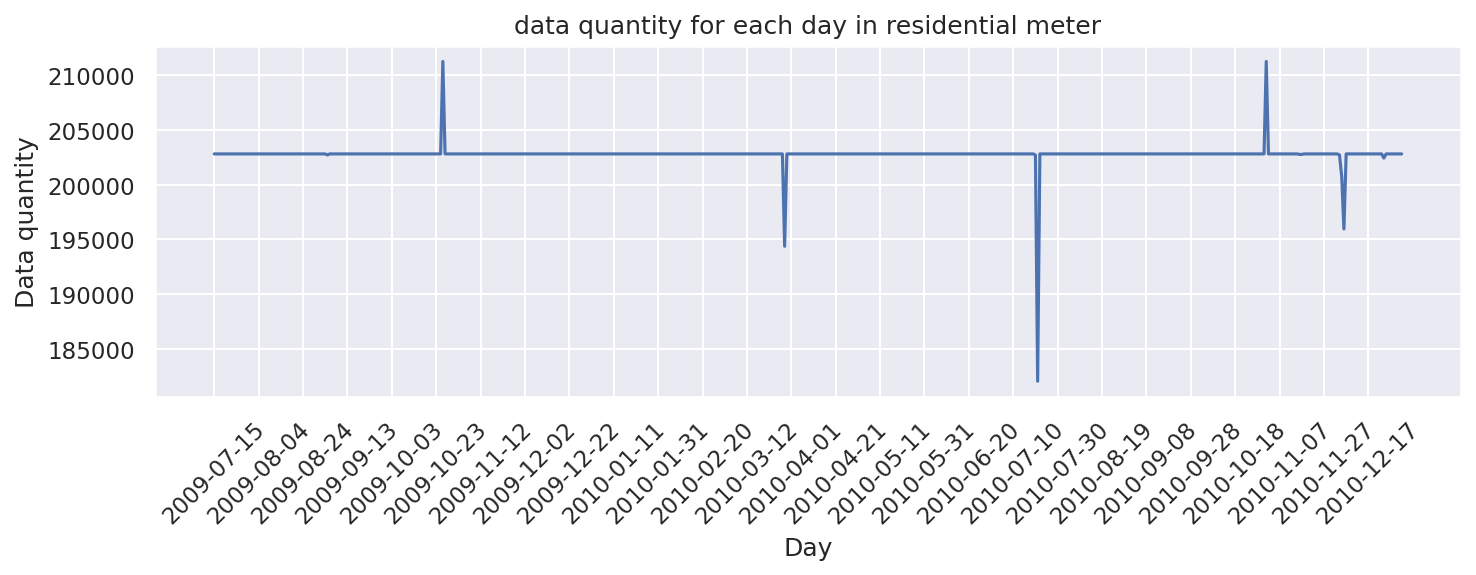

In [12]:
plot_day_data(load_data["Day"].value_counts().sort_index(), title="data quantity for each day in residential meter", save=True)

### select time interval

before drop Datetime between 19501 and 72948:  (108678770, 5)
after drop Datetime between 19501 and 72948:  (108475970, 5)
Saving figure data quantity in select time 2009.7.15-2010.12.31
(108475970, 5)
before drop Datetime between 73001 and 73048:  (108475970, 5)
after drop Datetime between 73001 and 73048:  (0, 5)


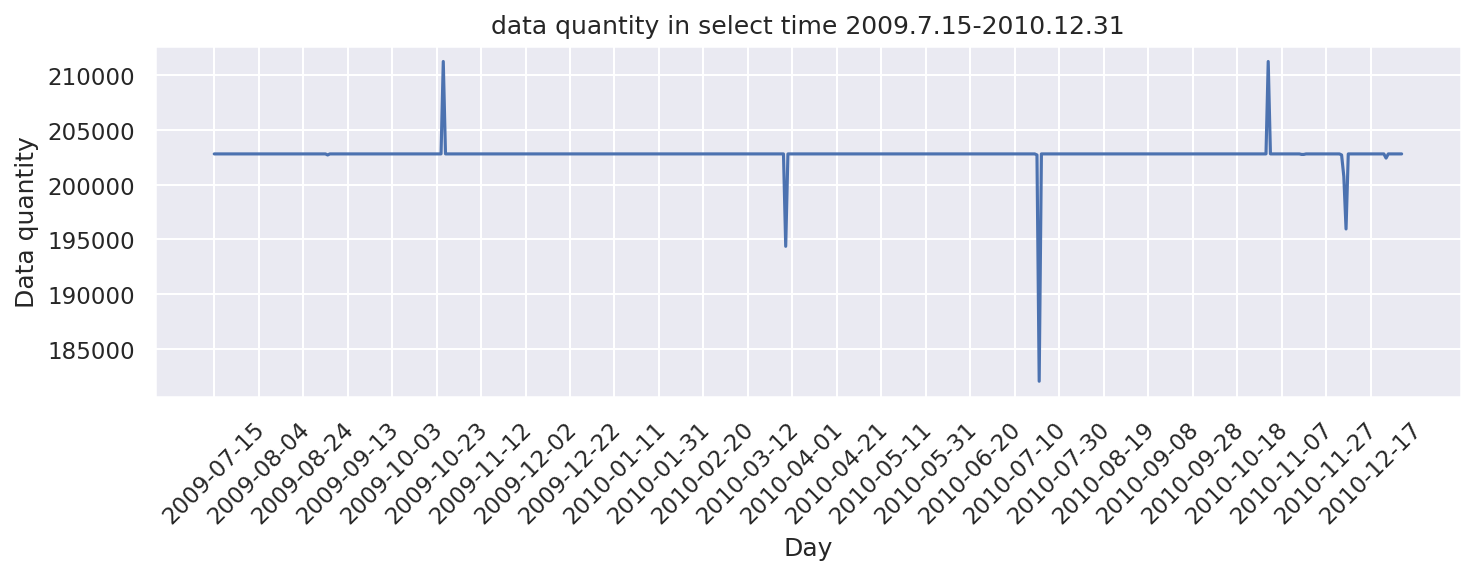

In [13]:
load_data = data_cleaning_select_time(load_data,19501,72948)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="data quantity in select time 2009.7.15-2010.12.31", save=True)
print(load_data.shape)
data_20110101 = data_cleaning_select_time(load_data,73001,73048)

### drop more than 48 hours

before drop Time: (108475970, 5)
after drop Time:  (108459070, 5)
Saving figure drop data more than 48 hours a day
(108459070, 5)


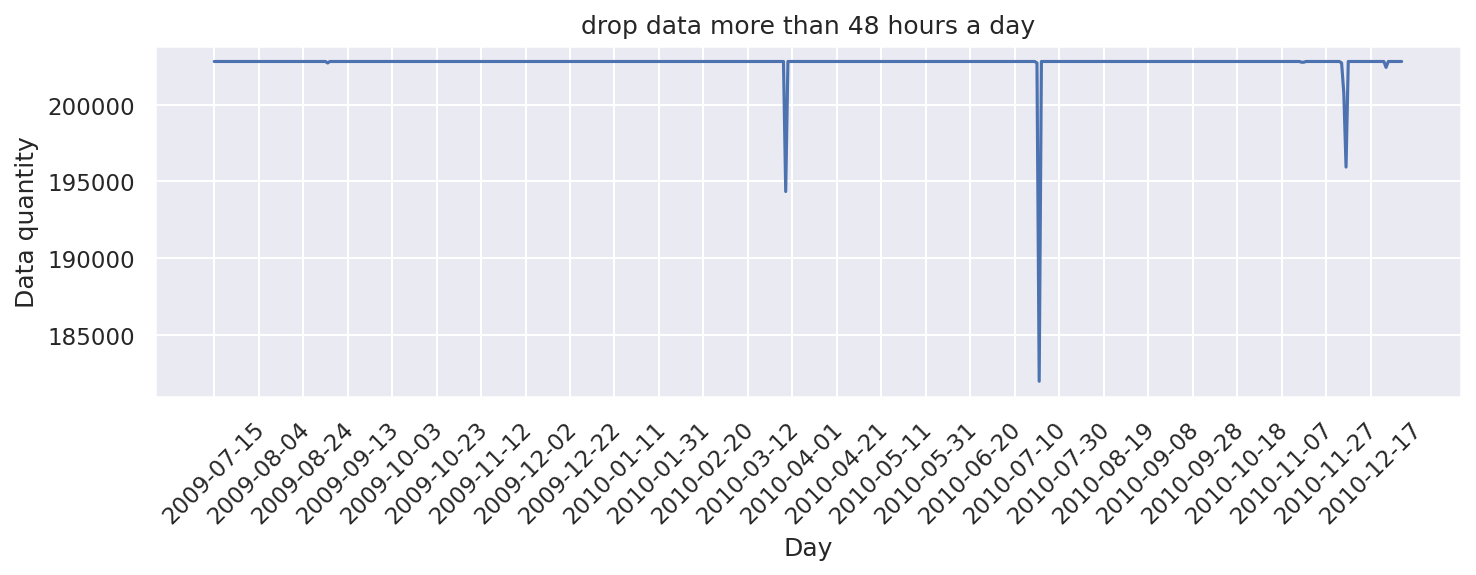

In [14]:
load_data = data_cleaning_drop_48(load_data)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="drop data more than 48 hours a day", save=True)
print(load_data.shape)

### drop missing value

 2010-12-24    202416
 2010-12-05    200736
 2010-12-06    195936
 2010-03-29    194350
 2010-07-21    182016

Saving figure drop data with day missing
(107483616, 5)


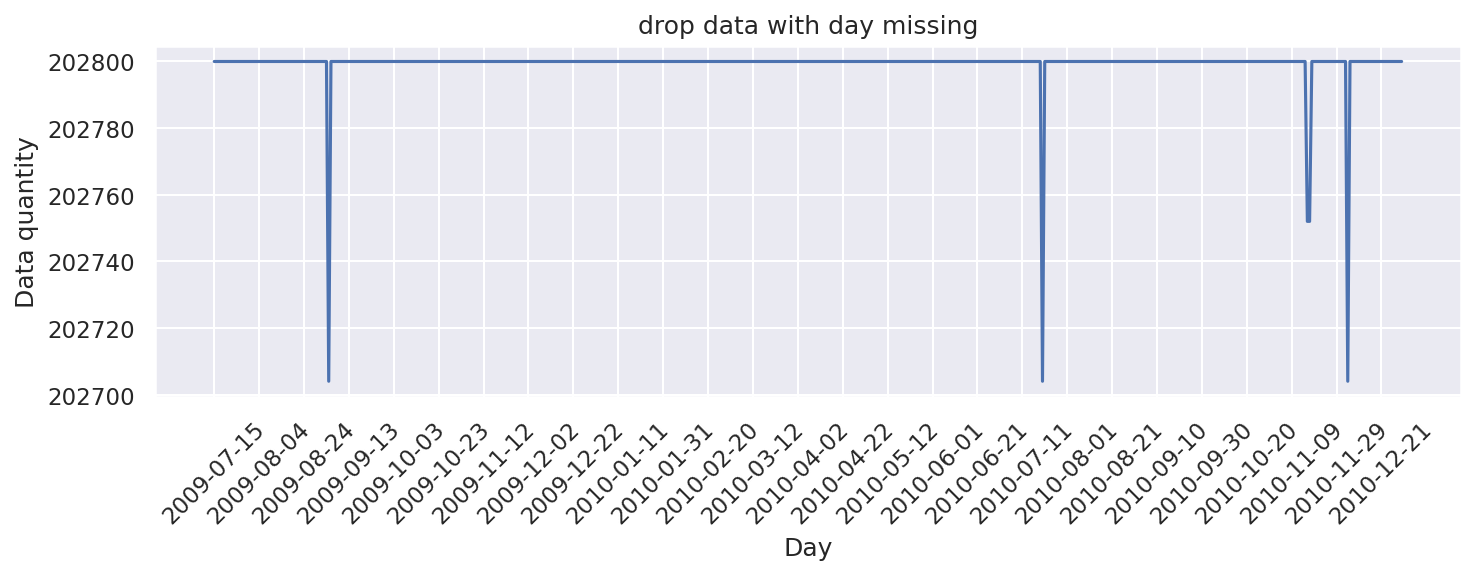

In [15]:
# drop data with day missing
drop_Day_missing = ["2010-03-29", "2010-12-24", "2010-12-05", "2010-12-06", "2010-07-21"]
load_data = drop_meter_from_df(load_data, "Day", drop_Day_missing)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="drop data with day missing", save=True)
print(load_data.shape)

### replace missing value

 2010-11-17    202752
 2010-11-16    202752
 2009-09-04    202704
 2010-07-20    202704
 2010-12-04    202704

In [16]:
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-11-16"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-11-17"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2009-09-04"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-07-20"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-12-04"]["MeterID"].unique()))

{4463}
{4463}
{5313, 2715}
{3433, 5181}
{2728, 1505}


In [17]:
load_data = replace_missing_value(load_data, 4463, "2010-11-15", "2010-11-16", 1)
load_data = replace_missing_value(load_data, 4463, "2010-11-14", "2010-11-17", 1)
load_data = replace_missing_value(load_data, 2715, "2009-09-03", "2009-09-04", 1)
load_data = replace_missing_value(load_data, 5313, "2009-09-03", "2009-09-04", 1)
load_data = replace_missing_value(load_data, 3433, "2010-07-19", "2010-07-20", 1)
load_data = replace_missing_value(load_data, 5181, "2010-07-19", "2010-07-20", 1)
load_data = replace_missing_value(load_data, 1505, "2010-12-03", "2010-12-04", 1)
load_data = replace_missing_value(load_data, 2728, "2010-12-03", "2010-12-04", 1)

,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
22608208,4463,2010-11-16,1,0.479,68401
22608209,4463,2010-11-16,2,0.409,68402


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
22608160,4463,2010-11-17,1,0.441,68301
22608161,4463,2010-11-17,2,0.405,68302


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
2371104,2715,2009-09-04,1,0.089,24601
2371105,2715,2009-09-04,2,0.048,24602


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
2379264,5313,2009-09-04,1,0.154,24601
2379265,5313,2009-09-04,2,0.179,24602


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
17088619,3433,2010-07-20,1,0.611,56501
17088620,3433,2010-07-20,2,0.253,56502


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
17107983,5181,2010-07-20,1,0.558,56501
17107988,5181,2010-07-20,2,0.548,56502


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
23198590,1505,2010-12-04,1,0.0,70201
23198591,1505,2010-12-04,2,0.0,70202


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
23201700,2728,2010-12-04,1,0.923,70201
23201701,2728,2010-12-04,2,0.253,70202


Saving figure fill data with day missing
(107484000, 5)


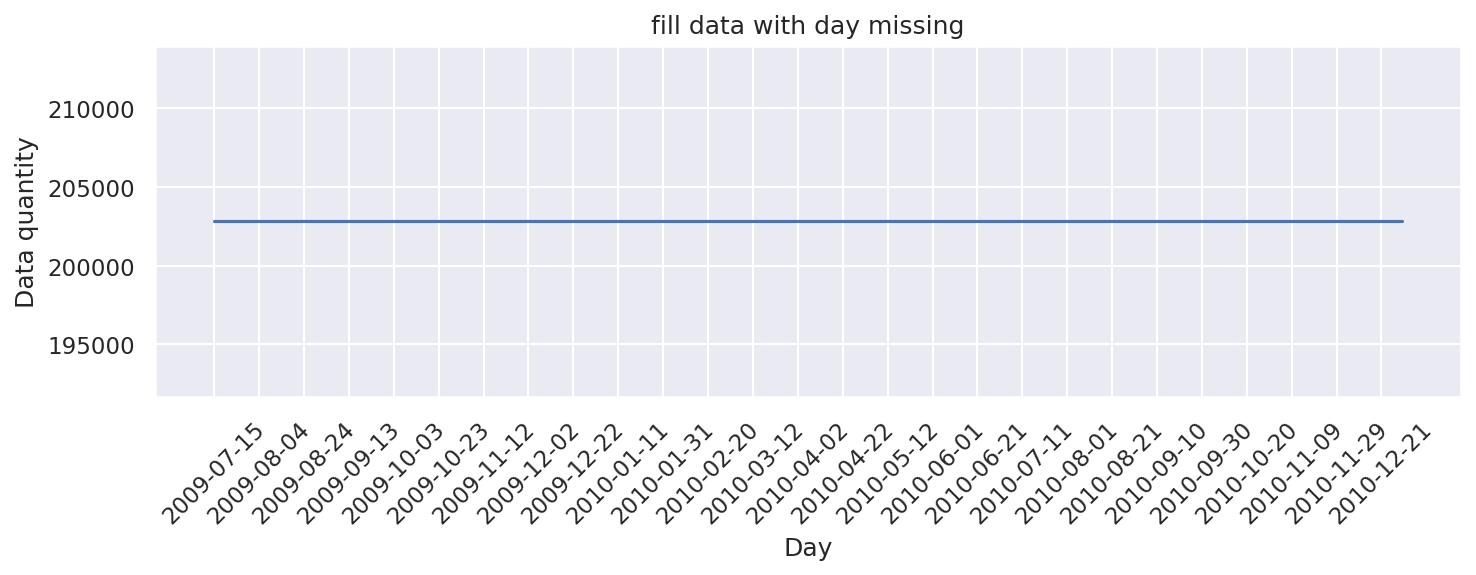

In [18]:
plot_day_data(load_data["Day"].value_counts().sort_index(), title="fill data with day missing", save=True)
print(load_data.shape)

In [19]:
del data
del d
del df_sme
del d_is_res
del res_list
del d_is_res_and_date
del res_data_list
gc.collect()

19085

## Meter grouping

In [20]:
pretty_data = load_data.sort_values(by=['MeterID', 'Day'])

In [21]:
# FDI CONST
NUMBER_OF_DAYS = len(pretty_data["Day"].unique())
NUMBER_OF_HALF_HOURS = NUMBER_OF_DAYS * 48
AREA_NUM = 10
TOTAL_METER = len(pretty_data.groupby("MeterID")["MeterID"].unique())
METER_IN_RANGE = round(len(pretty_data.groupby("MeterID")["MeterID"].unique()) / AREA_NUM)

In [22]:
NUMBER_OF_DAYS, NUMBER_OF_HALF_HOURS, TOTAL_METER, METER_IN_RANGE

(530, 25440, 4225, 422)

In [23]:
# split data into groups
def split_data_to_group(target_df, areas):
    data_group = {}
    for group in range(areas):
        if group == (AREA_NUM - 1):
            data_group[group] = target_df[METER_IN_RANGE*group*(NUMBER_OF_HALF_HOURS) : METER_IN_RANGE*(group+1)*(NUMBER_OF_HALF_HOURS)+NUMBER_OF_HALF_HOURS* (TOTAL_METER % areas)]
        else:
            data_group[group] = target_df[METER_IN_RANGE*group*(NUMBER_OF_HALF_HOURS) : METER_IN_RANGE*(group+1)*(NUMBER_OF_HALF_HOURS)]
    return data_group

In [24]:
# split data into 10 groups
data_group = split_data_to_group(pretty_data, AREA_NUM)

## FDI

In [28]:
class FdiGenerator:
    def __init__(self):
        self.alpha_max = 0.8
        self.alpha_min = 0.2
    
    # x is the origin value

    def fdi_1(self, x):
        fdi =  x * self.get_alpha()
        return fdi

    def fdi_2(self, x, df_max):
        alpha = self.get_alpha()
        gamma = alpha * df_max
        return gamma if (x > gamma) else x

    def fdi_3(self, x, df_max):
        gamma = np.random.uniform(0, 1) * df_max
        return max((x - gamma), 0)
    
    def fdi_4(self, x, index, total_index):
        t2 = np.random.randint(0, 20)
        t1 = np.random.randint(t2, 24)
        if index > t2 and index < t2:
            return 0
        return x
    
    def fdi_5(self, x, index):
        alpha = self.get_alpha()
        return x * alpha
    
    def fdi_6(self, avg_x):
        alpha = self.get_alpha()
        return avg_x * alpha
    
    def get_alpha(self):
        return np.random.uniform(self.alpha_min, self.alpha_max)
    
    def get_random_mode(self):
        # return an integer in range from 1 to 6
        fdi_method = np.random.randint(1, 7)
        return fdi_method
    
    def random_fdi(self, fdi_method, x, df, index):
        # return a fdi value with fdi_method provided
        if fdi_method == 1:
            return self.fdi_1(x)
        elif fdi_method == 2:
            return self.fdi_2(x, df.max())
        elif fdi_method == 3:
            return self.fdi_3(x, df.max())
        elif fdi_method == 4:
            return self.fdi_4(x, index, df.shape[0])
        elif fdi_method == 5:
            return self.fdi_5(x, index)
        else:
            return self.fdi_6(df.mean())

In [65]:
def split_group(group, total_meter, area_num, group_meter, total_day, ntl_meter_ratio, ntl_day_ratio):
    # ex: split_group(data_group, total_meter = 2044, group_meter = 204, total_day = 299, ntl_meter_ratio = 0.1, ntl_day_ratio = 0.5)

    ntl_num = round(group_meter * ntl_meter_ratio) # ntl_num = how many number of ntl meters
    ntl_day_num = round(total_day * ntl_day_ratio) # ntl_day_num = how many days are fdi for ntl meters
    
    np.random.seed(42)
    
    final_data_group = []
    origin_data_group = []
    data_group = copy.deepcopy(group) 
    
    # iterate through 10 area
    for group, data in data_group.items():
        
        final_data = {}
        origin_data = {}

        normal_data = []
        fdi_data = []
        origin_fdi_data = []

        if group == (area_num - 1): # the last group will have more data for the rest of the meters
            num = total_meter - group_meter * (area_num -1)
        else:
            num = group_meter

        #split total meter into normal meters and fdi meters
        rs = ShuffleSplit(n_splits=1, test_size=ntl_num)
        for normal_index, fdi_index in rs.split(range(num)):
            for index in normal_index:
                normal_data.append(data[index*(NUMBER_OF_HALF_HOURS):(index+1)*(NUMBER_OF_HALF_HOURS)])
            for index in fdi_index:
                fdi_data.append(data[index*(NUMBER_OF_HALF_HOURS):(index+1)*(NUMBER_OF_HALF_HOURS)])
                
        origin_fdi_data = copy.deepcopy(fdi_data)
            
        for index in tq.tqdm(range(len(fdi_data))):
            
            dataframe = fdi_data[index]
            fdi_dataframe = np.zeros((NUMBER_OF_HALF_HOURS))
            fdi_label = np.zeros((NUMBER_OF_HALF_HOURS))
            normal_label = np.zeros((NUMBER_OF_HALF_HOURS))
            
            # split total day into normal and fdi day with the ntl_day_num
            rs = ShuffleSplit(n_splits=1, test_size=ntl_day_num, random_state=42)
            for normal_day, fdi_day in rs.split(range(total_day)):
                normal_day = normal_day
                fdi_day = fdi_day
            
            # set normal data in normal days
            for day in range(len(normal_day)):
                for i in range(normal_day[day]*48, (normal_day[day]+1)*48):
                    fdi_dataframe[i] = dataframe["Electricity"].iloc[[i]]
                    
            
            # process FDI in fdi days
            for day in range(len(fdi_day)):
                for i in range(fdi_day[day]*48, (fdi_day[day]+1)*48):
                    
                    # one day has 48 data, so every 48 will change a fdi mode
                    if i%48 == 0:
                        fdi_method = FDI.get_random_mode()
                    
                    origin_value = dataframe["Electricity"].iloc[i]
                    fdi_dataframe[i] = FDI.random_fdi(fdi_method, origin_value, dataframe["Electricity"], i)
                    fdi_label[i] = 1

            fdi_data[index]["Electricity"] = fdi_dataframe
            fdi_data[index]["FDI"] = fdi_label #for fdi day, fdi flag is 1, otherwise, flag is 0
            normal_data[index]["FDI"] = normal_label

        final_data["normal"] = normal_data
        final_data["fdi"] = fdi_data
        final_data_group.append(final_data) 

        origin_data["normal"] = normal_data
        origin_data["fdi"] = origin_fdi_data
        origin_data_group.append(origin_data)
        
        
#         return final_data_group, origin_data_group

    return final_data_group, origin_data_group

In [66]:
FDI = FdiGenerator()
final_data_group, origin_data_group = split_group(data_group, total_meter=TOTAL_METER, area_num=AREA_NUM, total_day=NUMBER_OF_DAYS, group_meter=METER_IN_RANGE, ntl_meter_ratio=0.1, ntl_day_ratio=0.5)

  0%|          | 0/42 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [72]:
for i in final_data_group:
    print(i['normal'][0])
    t = i['fdi'][0]
    print(i['fdi'][0])
    break

          MeterID         Day  Time  Electricity  Datetime  FDI
192076       1665  2009-07-15     1        0.095     19501  0.0
192077       1665  2009-07-15     2        0.218     19502  0.0
192078       1665  2009-07-15     3        0.096     19503  0.0
192079       1665  2009-07-15     4        0.571     19504  0.0
192080       1665  2009-07-15     5        0.124     19505  0.0
...           ...         ...   ...          ...       ...  ...
24357497     1665  2010-12-31    44        0.713     72944  0.0
24357498     1665  2010-12-31    45        0.664     72945  0.0
24357499     1665  2010-12-31    46        0.624     72946  0.0
24357500     1665  2010-12-31    47        0.694     72947  0.0
24357501     1665  2010-12-31    48        0.634     72948  0.0

[25440 rows x 6 columns]
          MeterID         Day  Time  Electricity  Datetime  FDI
206066       1236  2009-07-15     1     0.134070     19501  1.0
206067       1236  2009-07-15     2     0.129562     19502  1.0
206068       1

In [29]:
def plot_data(normal_data, fdi_data, title, label1, label2, plot_house=5, plot_hour=120, save=False):
    #plotting the points  
    plt.figure(dpi=150, figsize=(15,4))
    if normal_data is not None:
        count = 0
    for i in range(len(normal_data)):
        data = normal_data[i]["Electricity"]
        count += 1
        if count>plot_house:
            break
        plt.plot(HOURS_LIST[:plot_hour], data[:plot_hour], color='blue') 

    if fdi_data is not None:
        count = 0
    for i in range(len(fdi_data)):
        data = fdi_data[i]["Electricity"]
        count += 1
        if count>plot_house:
            break
        plt.plot(HOURS_LIST[:plot_hour], data[:plot_hour], color='red')
    
    
    blue_patch = mpatches.Patch(color='blue', label=label1)
    red_patch = mpatches.Patch(color='red', label=label2)
    plt.legend(handles=[blue_patch, red_patch])       
        
    # naming the x axis 
    plt.xlabel('Half Hours') 
    # naming the y axis 
    plt.ylabel('Electricity Consumption(W)') 

    # giving a title to my graph 
    plt.title(title) 

    # function to save the plot
    if save == True:
        save_fig(title)

    # function to show the plot 
    plt.show()

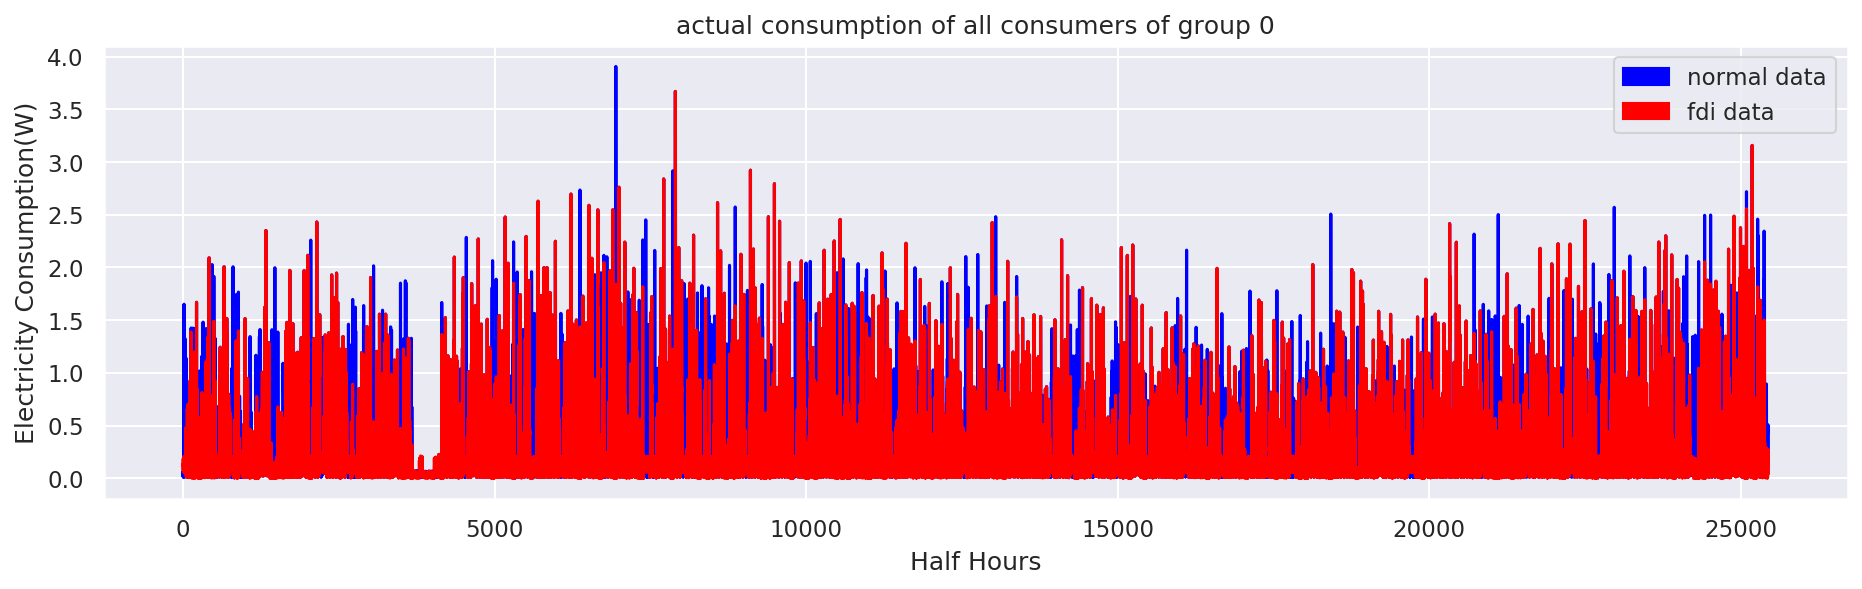

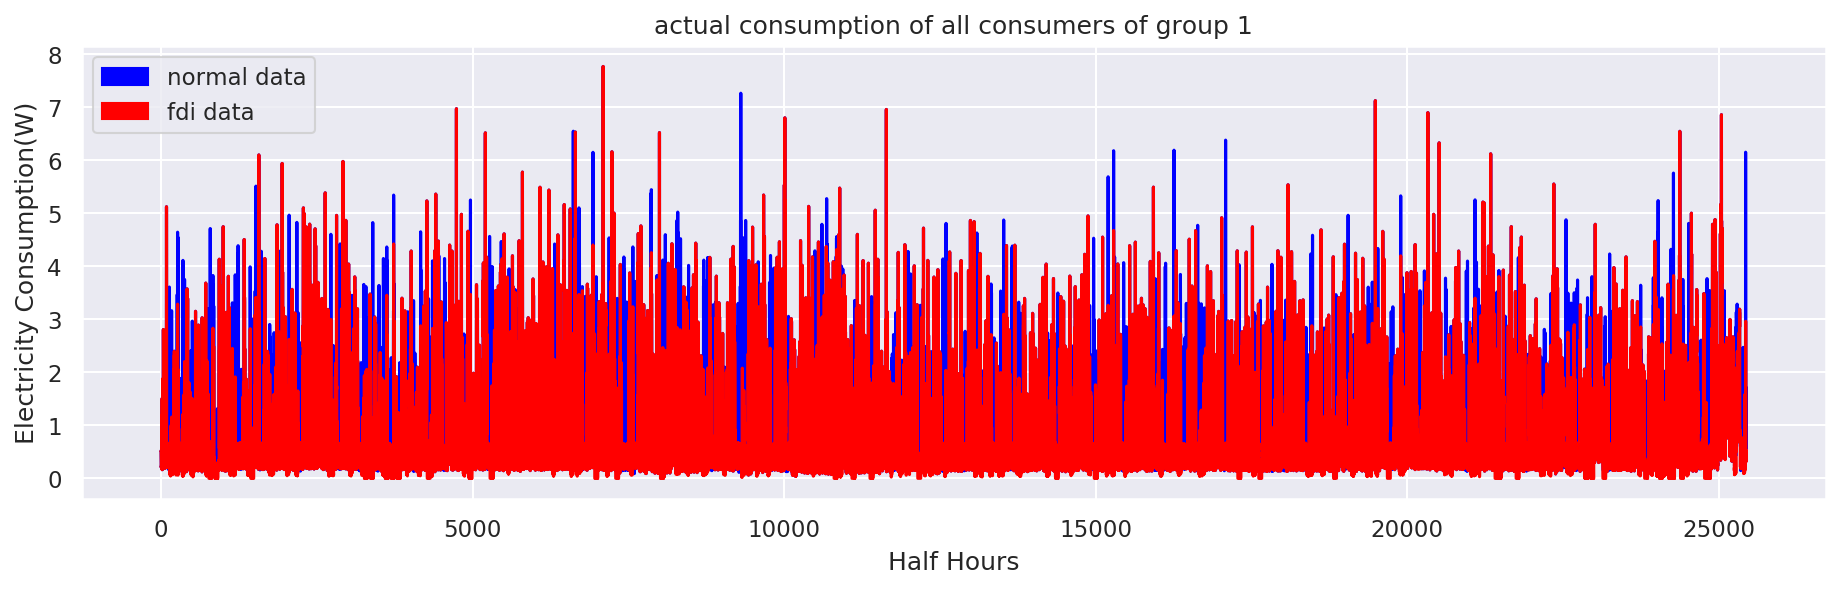

In [30]:
for i in range(len(final_data_group)):
    if i == 2: break
    plot_data(origin_data_group[i]["fdi"], final_data_group[i]["fdi"], "actual consumption of all consumers of group " + str(i), "normal data", "fdi data", plot_house=1, plot_hour=NUMBER_OF_HALF_HOURS, save=False)

## check NTL

In [31]:
# observe_meter_data_group = copy.deepcopy(origin_data_group) ## data without fdi
# smart_meter_data_group = copy.deepcopy(final_data_group) ## data with fdi
observe_meter_data_group = origin_data_group ## data without fdi
smart_meter_data_group = final_data_group ## data with fdi

In [32]:
# calculate NTL loss vector for every day
ntl_loss_data_group = []
for observe_area, smart_area in zip(observe_meter_data_group, smart_meter_data_group): # iterate 10 area
    ntl_loss_data = []
    for observe_meter, smart_meter in zip(observe_area['fdi'], smart_area['fdi']): #iterate fdi meter in each area
        
        sub = observe_meter[["Electricity"]] - smart_meter[["Electricity"]]

        ntl_loss_data = sub.to_numpy().reshape(NUMBER_OF_DAYS, 48) 

    ntl_loss_data_group.append(ntl_loss_data)
ntl_loss_data_group = np.asarray(ntl_loss_data_group)
ntl_loss_data_group.shape

(10, 530, 48)

0.000000    16306
0.012000      214
0.013000      113
0.066000       53
0.011000       43
            ...  
0.055015        1
0.284542        1
0.007365        1
0.002946        1
0.353000        1
Name: Electricity, Length: 7300, dtype: int64


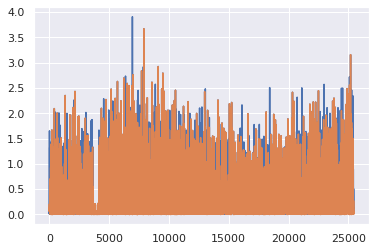

In [33]:
# make sure there is difference between the observe_meter_data_group and smart_meter_data_group
plt.plot(observe_meter_data_group[0]["fdi"][0]["Electricity"].tolist())
plt.plot(smart_meter_data_group[0]["fdi"][0]["Electricity"].tolist()) 
for j in range(1):
    t = observe_meter_data_group[0]["fdi"][j]["Electricity"] - smart_meter_data_group[0]["fdi"][j]["Electricity"]
    print(t.value_counts())

# k-mean index

In [52]:
X = []
X_meter = []
Y = []
for i in range(10):
    data = final_data_group[i]
    for normal in data["normal"]:
        X.append(normal["Electricity"].to_numpy())
        X_meter.append(normal["MeterID"].iloc[0])
        Y.append([0])
    for fdi in data["fdi"]:
        X.append(fdi["Electricity"].to_numpy())
        X_meter.append(normal["MeterID"].iloc[0])
        Y.append([1])
X = np.array(X)
X_meter = np.array(X_meter)
Y = np.array(Y).reshape(-1)
print(X.shape)

(4225, 25440)


In [1]:
print(Y.shape)

NameError: name 'Y' is not defined

### silhouette index

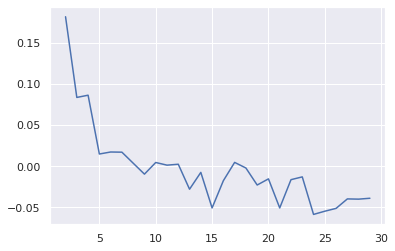

In [288]:
# silhouette index
silhouette_avg = []
for i in tq.tqdm(range(2,30)):
    kmeans_fit = KMeans(n_clusters = i).fit(X)
    silhouette_avg.append(silhouette_score(X, kmeans_fit.labels_))
plt.plot(range(2,30), silhouette_avg)

Saving figure Silhouette analysis in fdi data


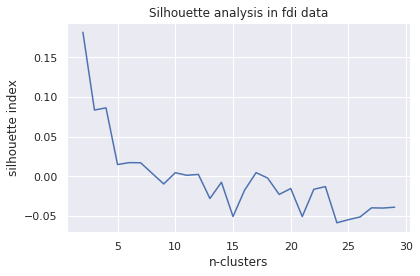

In [295]:
plt.title("Silhouette analysis in fdi data")
plt.xlabel('n-clusters') 
# naming the y axis 
plt.ylabel('silhouette index') 
plt.plot(range(2,30), silhouette_avg)
save_fig("Silhouette analysis in fdi data")

# feature extraction

## V-value

### normalization

In [34]:
# the value of x is divided by its
# maximum and scaled into a value between zero and one
# normalized smart_meter_data_group by divide the max eletricity of the meter
for area in smart_meter_data_group:
    for meter in area['fdi']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
    for meter in area['normal']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
smart_meter_data_group[0]['fdi'][0]['Electricity'].to_numpy()

array([0.03654134, 0.03531269, 0.03096642, ..., 0.04361966, 0.03120148,
       0.0111179 ])

0.008729    1082
0.009457     719
0.048011     301
0.047284     276
0.048739     271
            ... 
0.596000       1
0.060656       1
0.209471       1
0.002350       1
1.041703       1
Name: Electricity, Length: 8762, dtype: int64


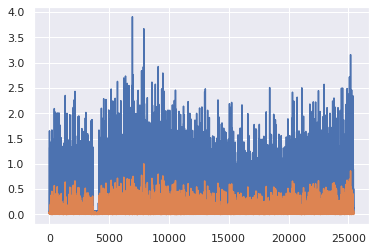

In [35]:
# make sure there is difference between the observe_meter_data_group and smart_meter_data_group
plt.plot(observe_meter_data_group[0]["fdi"][0]["Electricity"].tolist())
plt.plot(smart_meter_data_group[0]["fdi"][0]["Electricity"].tolist()) 
for j in range(1):
    t = observe_meter_data_group[0]["fdi"][j]["Electricity"] - smart_meter_data_group[0]["fdi"][j]["Electricity"]
    print(t.value_counts())

### calculate v-value

In [36]:
CONDITION_FILTER = 28
v_value_list = []
v_value_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI', 'Tmax1', 'Cmax1', 'Tmax2', 'Cmax2', 'Tmin1', 'Cmin1'])
pbar = tqdm(smart_meter_data_group) 
for area in pbar: # iterate 10 data groups
    for meter in area['fdi']: # iterate every fdi meter in area 
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            meter_numpy = meter['Electricity'].to_numpy()[i*48:(i+1)*48]

            # 1. Cmax1 and T max1 are the maximum consumption before 2 p.m.
            Tmax1 = meter_numpy[:CONDITION_FILTER].argmax()
            
            # 2. Cmax2 and T max2 are the maximum consumption after 2 p.m.
            Tmax2 = meter_numpy[CONDITION_FILTER:].argmax() + CONDITION_FILTER
            
            # 3. Cmin1 and T min1 are the minimum consumption between T max1 and T max2 
            Tmin1 = meter_numpy[Tmax1: Tmax2].argmin() + Tmax1
            
            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': True, 'Tmax1': Tmax1, 'Tmax2': Tmax2, 'Tmin1': Tmin1, 'Cmax1': meter_numpy[Tmax1], 'Cmax2': meter_numpy[Tmax2], 'Cmin1': meter_numpy[Tmin1]}
            v_value_list.append(se)
    print('finish fdi')
    for meter in area['normal']:
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            meter_numpy = meter['Electricity'].to_numpy()[i*48:(i+1)*48]
#             print(meter_numpy)
            # 1. Cmax1 and T max1 are the maximum consumption before 2 p.m.
            Tmax1 = meter_numpy[:CONDITION_FILTER].argmax()
            
            # 2. Cmax2 and T max2 are the maximum consumption after 2 p.m.
            Tmax2 = meter_numpy[CONDITION_FILTER:].argmax() + CONDITION_FILTER
            
            # 3. Cmin1 and T min1 are the minimum consumption between T max1 and T max2 
            Tmin1 = meter_numpy[Tmax1: Tmax2].argmin() + Tmax1
            
            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': False, 'Tmax1': Tmax1, 'Tmax2': Tmax2, 'Tmin1': Tmin1, 'Cmax1': meter_numpy[Tmax1], 'Cmax2': meter_numpy[Tmax2], 'Cmin1': meter_numpy[Tmin1]}
            v_value_list.append(se)
    print('finish normal')

finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal



In [41]:
df = pd.DataFrame(v_value_list)
df.head(), df.shape

(   MeterID         Day   FDI  Tmax1  Tmax2  Tmin1     Cmax1     Cmax2     Cmin1
 0     1236  2009-07-15  True     12     30     15  0.055917  0.057202  0.016320
 1     1236  2009-07-16  True     20     34     24  0.178795  0.192423  0.003271
 2     1236  2009-07-17  True     18     35     24  0.252112  0.378032  0.005451
 3     1236  2009-07-18  True      0     35      0  0.000000  0.326571  0.000000
 4     1236  2009-07-19  True     25     36     29  0.454892  0.231671  0.024530,
 (2239250, 9))

In [38]:
e = df.to_csv(index=False)
f = open('v_value.csv','w')
f.write(e) #Give your csv text here.
## Python will convert \n to os.linesep
f.close()

In [ ]:
del meter_day
del meter_id
del meter_numpy
del e
del f
del df
gc.collect()

### calculate distance

In [193]:
def dV(i,j):
    return ( (i.Tmax1-j.Tmax1)**2 + (i.Cmax1-j.Cmax1)**2 )**0.5 + ( (i.Tmax2-j.Tmax2)**2 + (i.Cmax2-j.Cmax2)**2 )**0.5 + ( (i.Tmin1-j.Tmin1)**2 + (i.Cmin1-j.Cmin1)**2 )**0.5

In [ ]:
vvalue_distance_matrix = []
for indexi, rowi in tq.tqdm(df.iterrows()):
    i_j_distance_arr = []
    for indexj, rowj in tq.tqdm(df.iterrows()):
        if indexi > indexj:
            i_j_distance_arr.append(vvalue_distance_matrix[indexj][indexi])
            continue
        i_j_distance_arr.append(dV(rowi, rowj))
    vvalue_distance_matrix.append(i_j_distance_arr)

### v_value silhouette index

In [45]:
df.head()

,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,1236,2009-07-15,True,12,30,15,0.055917,0.057202,0.016320
1,1236,2009-07-16,True,20,34,24,0.178795,0.192423,0.003271
2,1236,2009-07-17,True,18,35,24,0.252112,0.378032,0.005451
3,1236,2009-07-18,True,0,35,0,0.000000,0.326571,0.000000
4,1236,2009-07-19,True,25,36,29,0.454892,0.231671,0.024530


In [51]:
X = df[['Tmax1', 'Cmax1', 'Tmax2', 'Cmax2', 'Tmin1', 'Cmin1']].to_numpy()

In [ ]:
# silhouette index
silhouette_avg = []
for i in tq.tqdm(range(2,15)):
    kmeans_fit = KMeans(n_clusters = i).fit(X)
    silhouette_avg.append(silhouette_score(X, kmeans_fit.labels_))
plt.plot(range(2,30), silhouette_avg)

In [ ]:
1

## four time interval

1) Time Period 1: 10.30 P.M.–6.30 A.M.—overnight period (45:14)   
2) Time Period 2: 6.30–9.00 A.M.—breakfast period (14:18)   
3) Time Period 3: 9.00 A.M.–3.30 P.M.—daytime period (18:31)   
4) Time Period 4: 3.30–10.30 P.M.—evening period.(31:45)   

In [ ]:
for i in smart_meter_data_group:
    for j in i:
        print(i[j][0])
        temp = i[j][0]
        break
    break

In [ ]:
temp['MeterID'].value_counts()

In [ ]:
df_list = []
pbar = tqdm(smart_meter_data_group) 
for area in pbar: # iterate 10 data groups
    for meter in area['fdi']: # iterate every fdi meter in area 
        display(meter)
        day_list = meter['Day']
        print(day_list)
        for i in range(NUMBER_OF_DAYS): # iterate every day
            
            meter_id = meter['MeterID'].max()
            meter_day = day_list[i]
            meter_numpy = meter['Electricity'].to_numpy()[i*48:(i+1)*48]
            if i == 529:
                print()
            print(i, meter_id, meter_day)
        break
    break
#     for normal in data["normal"]:
#         for i in range(NUMBER_OF_DAYS)


In [ ]:
1

## MIC

In [ ]:
# change the data structure for mic
smart_meter_data_mic = []
for area in smart_meter_data_group:
    
    for meter in area['fdi']:
        t = meter['Electricity'].to_numpy().reshape(30, 48)
        smart_meter_data_mic.append(t)
    for meter in area['normal']:
        t = meter['Electricity'].to_numpy().reshape(30, 48)
        smart_meter_data_mic.append(t)
        
smart_meter_data_mic = np.asarray(smart_meter_data_mic)

In [ ]:
# calculate MIC 
m = MINE(alpha=0.8)
mic_result = []

area_count = 0 
area = 0

#iterate every i consumer on j day 
for i in range(len(smart_meter_data_mic)):
    j_arr = np.zeros(len(smart_meter_data_mic[i]))
    
    # get area number by user
    if area_count == 39 and area == 9:
        pass
    elif (area_count - 39) == 0:
        area += 1
        area_count = 0
    
    # iterate 30 day for every i consumer
    for j in range(len(smart_meter_data_mic[i])):
        
        u = smart_meter_data_mic[i][j] # 1 * 48 
        # e = ntl_loss_data
        # e = normalized_nlt_loss_data
        ntl_loss_data = ntl_loss_data_group[area][j]

        e = ntl_loss_data # 1 * 48
        
        m.compute_score(u, e)

        j_arr[j] = m.mic()

    area_count += 1
    mic_result.append(j_arr)
mic_result = np.asarray(mic_result)

### merge feature(vvalue)

In [ ]:
temp = pd.read_csv('v_value.csv')

In [ ]:
temp

In [ ]:
new_df = pd.merge(A_df, temp,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])

In [58]:
# normalized smart_meter_data_group by divide the max eletricity of the meter
for area in smart_meter_data_group:
    for meter in area['fdi']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
    for meter in area['normal']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
smart_meter_data_group[0]['fdi'][0]['Electricity'].to_numpy()

array([0.1206073 , 0.12691914, 0.0996247 , ..., 0.07830092, 0.14738997,
       0.08103037])

In [1]:
df_list = []
fourtime_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI', 'overnight', 'breakfast', 'daytime', 'evening'])
pbar = tqdm(smart_meter_data_group) 
for area in pbar: # iterate 10 data groups
    for meter in area['fdi']: # iterate every fdi meter in area 
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            
            if i == 0:
                meter_numpy = meter['Electricity'].to_numpy()[44:48]
                meter_numpy = np.append(meter_numpy, meter['Time'].to_numpy()[i*48:(i+1)*48-4])
            else:
                meter_numpy = meter['Electricity'].to_numpy()[i*48-4:(i+1)*48-4]
            
            overnight = np.average(meter_numpy[0:17])
            breakfast = np.average(meter_numpy[17:21])
            daytime = np.average(meter_numpy[21:35])
            evening = np.average(meter_numpy[35:48])

            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': True, 'overnight': overnight, 'breakfast': breakfast, 'daytime': daytime, 'evening': evening}
            df_list.append(se)
            
    for meter in area['normal']: # iterate every fdi meter in area 
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            
            if i == 0:
                meter_numpy = meter['Electricity'].to_numpy()[44:48]
                meter_numpy = np.append(meter_numpy, meter['Time'].to_numpy()[i*48:(i+1)*48-4])
            else:
                meter_numpy = meter['Electricity'].to_numpy()[i*48-4:(i+1)*48-4]
            
            overnight = np.average(meter_numpy[0:17])
            breakfast = np.average(meter_numpy[17:21])
            daytime = np.average(meter_numpy[21:35])
            evening = np.average(meter_numpy[35:48])

            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': False, 'overnight': overnight, 'breakfast': breakfast, 'daytime': daytime, 'evening': evening}
            df_list.append(se)


NameError: name 'pd' is not defined

# OLD

In [17]:
# drop data with duplicate meter
drop_MeterID_duplicate = 1208
pretty_data = drop_meter_from_df(pretty_data, "MeterID", drop_MeterID_duplicate)

#drop meter missing time 2 and 3 #pretty_shape_data[ (pretty_shape_data["Day"] == "2010-03-29") & (pretty_shape_data["MeterID"] == 2001) ]
drop_MeterID_missing = 2001
pretty_data = drop_meter_from_df(pretty_data, "MeterID", drop_MeterID_missing)

# drop data with day missing
drop_Day_missing = "2010-03-29"
pretty_data = drop_meter_from_df(pretty_data, "Day", drop_Day_missing)

# drop data has eletricity comsuption with 0
pretty_data = data_cleaning_drop_zero(pretty_data)

# drop data has more than 48 hours
pretty_data = data_cleaning_drop_48(pretty_data, 48)

# select data between Datetime 19501.0 and 49448.0
pretty_data = data_cleaning_select_time(pretty_data, 19501, 49448) # 62048

before drop zero: (100450124, 5)
after drop zero:  (95390376, 5)
before drop Time: (95390376, 5)
after drop Time:  (95375520, 5)
before drop Datetime between 19501 and 49448:  (95375520, 5)
after drop Datetime between 19501 and 49448:  (53303328, 5)


In [18]:
print_df_summary(pretty_data, all=True)

MeterID count : [14352]
Datetime count : [3714]
Day count : [178272]
Time count : [1110486]
Electricity count : [127987 127752 127670 ...      3      2      1]


14352    3714
Name: Time, dtype: int64


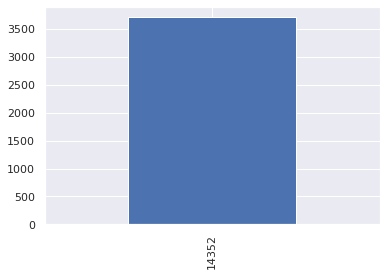

In [19]:
plot_df_valuecounts_with_groupby(pretty_data, "MeterID", "Time")

In [20]:
# FDI CONST
NUMBER_OF_DAYS = len(pretty_data["Day"].unique())
NUMBER_OF_HALF_HOURS = NUMBER_OF_DAYS * 48
AREA_NUM = 10
TOTAL_METER = len(pretty_data.groupby("MeterID")["MeterID"].unique())
METER_IN_RANGE = round(len(pretty_data.groupby("MeterID")["MeterID"].unique()) / AREA_NUM)

In [21]:
# split data into groups
def split_data_to_group(target_df, areas):
    data_group = {}
    for group in range(areas):
        if group == (AREA_NUM - 1):
            data_group[group] = target_df[METER_IN_RANGE*group*(NUMBER_OF_HALF_HOURS) : METER_IN_RANGE*(group+1)*(NUMBER_OF_HALF_HOURS)+NUMBER_OF_HALF_HOURS* (TOTAL_METER % areas)]
        else:
            data_group[group] = target_df[METER_IN_RANGE*group*(NUMBER_OF_HALF_HOURS):METER_IN_RANGE*(group+1)*(NUMBER_OF_HALF_HOURS)]
    return data_group

In [22]:
# split data into 10 groups
data_group = split_data_to_group(pretty_data, AREA_NUM)

In [23]:
class FdiGenerator:
    def __init__(self):
        self.alpha_max = 0.8
        self.alpha_min = 0.2
    
    # x is the origin value

    def fdi_1(self, x):
        fdi =  x * self.get_alpha()
        return fdi

    def fdi_2(self, x, df_max):
        alpha = self.get_alpha()
        gamma = alpha * df_max
        return gamma if (x > gamma) else x

    def fdi_3(self, x, df_max):
        gamma = np.random.uniform(0, 1) * df_max
        return max((x - gamma), 0)
    
    def fdi_4(self, x, index, total_index):
        t2 = np.random.randint(0, 20)
        t1 = np.random.randint(t2, 24)
        if index > t2 and index < t2:
            return 0
        return x
    
    def fdi_5(self, x, index):
        alpha = self.get_alpha()
        return x * alpha
    
    def fdi_6(self, avg_x):
        alpha = self.get_alpha()
        return avg_x * alpha
    
    def get_alpha(self):
        return np.random.uniform(self.alpha_min, self.alpha_max)
    
    def get_random_mode(self):
        # return an integer in range from 1 to 6
        fdi_method = np.random.randint(1, 7)
        return fdi_method
    
    def random_fdi(self, fdi_method, x, df, index):
        # return a fdi value with fdi_method provided
        if fdi_method == 1:
            return self.fdi_1(x)
        elif fdi_method == 2:
            return self.fdi_2(x, df.max())
        elif fdi_method == 3:
            return self.fdi_3(x, df.max())
        elif fdi_method == 4:
            return self.fdi_4(x, index, df.shape[0])
        elif fdi_method == 5:
            return self.fdi_5(x, index)
        else:
            return self.fdi_6(df.mean())

In [24]:
def split_group(group, total_meter, area_num, group_meter, total_day, ntl_meter_ratio, ntl_day_ratio):
    # ex: split_group(data_group, total_meter = 2044, group_meter = 204, total_day = 299, ntl_meter_ratio = 0.1, ntl_day_ratio = 0.5)

    ntl_num = round(group_meter * ntl_meter_ratio) # ntl_num = how many number of ntl meters
    ntl_day_num = round(total_day * ntl_day_ratio) # ntl_day_num = how many days are fdi for ntl meters
    
    np.random.seed(42)
    
    final_data_group = []
    origin_data_group = []
    data_group = copy.deepcopy(group) 
    
    # iterate through 10 area
    for group, data in data_group.items():
        final_data = {}
        origin_data = {}

        normal_data = []
        fdi_data = []
        origin_fdi_data = []

        if group == (area_num - 1): # the last group will have more data for the rest of the meters
            num = group_meter + total_meter % area_num
        else:
            num = group_meter

        #split total meter into normal meters and fdi meters
        rs = ShuffleSplit(n_splits=1, test_size=ntl_num)
        for normal_index, fdi_index in rs.split(range(num)):
            for index in normal_index:
                normal_data.append(data[index*(NUMBER_OF_HALF_HOURS):(index+1)*(NUMBER_OF_HALF_HOURS)])
            for index in fdi_index:
                fdi_data.append(data[index*(NUMBER_OF_HALF_HOURS):(index+1)*(NUMBER_OF_HALF_HOURS)])
                
        origin_fdi_data = copy.deepcopy(fdi_data)
            
        for index in tq.tqdm(range(len(fdi_data))):

            dataframe = fdi_data[index]
            fdi_dataframe = np.zeros((NUMBER_OF_HALF_HOURS))
            
            # split total day into normal and fdi day with the ntl_day_num
            rs = ShuffleSplit(n_splits=1, test_size=ntl_day_num, random_state=42)
            for normal_day, fdi_day in rs.split(range(total_day)):
                normal_day = normal_day
                fdi_day = fdi_day
            
            # set normal data in normal days
            for day in range(len(normal_day)):
                for i in range(normal_day[day]*48, (normal_day[day]+1)*48):
                    fdi_dataframe[i] = dataframe["Electricity"].iloc[[i]]
            
            # process FDI in fdi days
            for day in range(len(fdi_day)):
                  for i in range(fdi_day[day]*48, (fdi_day[day]+1)*48):
                        
                        # one day has 48 data, so every 48 will change a fdi mode
                        if i%48 == 0:
                            fdi_method = FDI.get_random_mode()
                        
                        origin_value = dataframe["Electricity"].iloc[i]
                        fdi_dataframe[i] = FDI.random_fdi(fdi_method, origin_value, dataframe["Electricity"], i)

            fdi_data[index]["Electricity"] = fdi_dataframe

        final_data["normal"] = normal_data
        final_data["fdi"] = fdi_data
        final_data_group.append(final_data) 

        origin_data["normal"] = normal_data
        origin_data["fdi"] = origin_fdi_data
        origin_data_group.append(origin_data)

    return final_data_group, origin_data_group

In [25]:
FDI = FdiGenerator()
final_data_group, origin_data_group = split_group(data_group, total_meter=TOTAL_METER, area_num=AREA_NUM, total_day=NUMBER_OF_DAYS, group_meter=METER_IN_RANGE, ntl_meter_ratio=0.1, ntl_day_ratio=0.5)

  0%|          | 0/37 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

In [44]:
def plot_data(normal_data, fdi_data, title, label1, label2, plot_house=5, plot_hour=120, save=False):
    #plotting the points  
    if normal_data is not None:
        count = 0
    for i in range(len(normal_data)):
        data = normal_data[i]["Electricity"]
        count += 1
        if count>plot_house:
            break
        plt.plot(HOURS_LIST[:plot_hour], data[:plot_hour], color='blue') 

    if fdi_data is not None:
        count = 0
    for i in range(len(fdi_data)):
        data = fdi_data[i]["Electricity"]
        count += 1
        if count>plot_house:
            break
        plt.plot(HOURS_LIST[:plot_hour], data[:plot_hour], color='red')

    blue_patch = mpatches.Patch(color='blue', label=label1)
    red_patch = mpatches.Patch(color='red', label=label2)
    plt.legend(handles=[blue_patch, red_patch])       
        
    # naming the x axis 
    plt.xlabel('Half Hours') 
    # naming the y axis 
    plt.ylabel('Electricity Consumption(W)') 

    # giving a title to my graph 
    plt.title(title) 

    # function to save the plot
    if save == True:
        save_fig(title)

    # function to show the plot 
    plt.show()
    
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, image_path=IMAGES_PATH):
    path = os.path.join(image_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

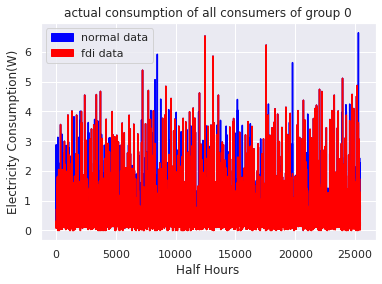

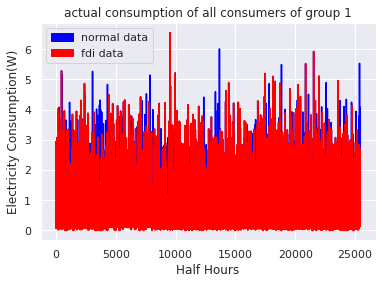

In [45]:
for i in range(len(final_data_group)):
    if i == 2: break
    plot_data(origin_data_group[i]["fdi"], final_data_group[i]["fdi"], "actual consumption of all consumers of group " + str(i), "normal data", "fdi data", plot_house=1, plot_hour=NUMBER_OF_HALF_HOURS)

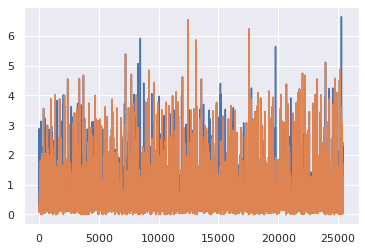

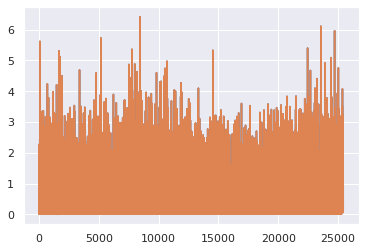

 0.000000    16302
 0.150000       38
 0.144000       36
 0.145000       35
 0.147000       32
             ...  
 0.025994        1
-0.101684        1
 0.114001        1
 1.376073        1
 0.208331        1
Name: Electricity, Length: 7292, dtype: int64


In [46]:
# calculate NTL
observe_meter_data_group = origin_data_group ## data without fdi
smart_meter_data_group = final_data_group ## data with fdi


# make sure there is difference between the observe_meter_data_group and smart_meter_data_group
plt.plot(observe_meter_data_group[0]["fdi"][0]["Electricity"].tolist())
plt.plot(smart_meter_data_group[0]["fdi"][0]["Electricity"].tolist()) 
plt.show()
plt.plot(observe_meter_data_group[0]["normal"][0]["Electricity"].tolist())
plt.plot(smart_meter_data_group[0]["normal"][0]["Electricity"].tolist()) 
plt.show()
for j in range(1):
    t = observe_meter_data_group[0]["fdi"][j]["Electricity"] - smart_meter_data_group[0]["fdi"][j]["Electricity"]
    print(t.value_counts())

In [47]:
# calculate NTL loss vector for every day
ntl_loss_data_group = []
for observe_area, smart_area in zip(observe_meter_data_group, smart_meter_data_group): # iterate 10 area
    ntl_loss_data = []
    for observe_meter, smart_meter in zip(observe_area['fdi'], smart_area['fdi']): #iterate fdi meter in each area
        
        sub = observe_meter[["Electricity"]] - smart_meter[["Electricity"]]

        ntl_loss_data = sub.to_numpy().reshape(NUMBER_OF_DAYS, 48) 

    ntl_loss_data_group.append(ntl_loss_data)
ntl_loss_data_group = np.asarray(ntl_loss_data_group)
ntl_loss_data_group.shape

(10, 530, 48)

In [30]:
# normalized smart_meter_data_group by divide the max eletricity of the meter
for area in smart_meter_data_group:
    for meter in area['fdi']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
    for meter in area['normal']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
smart_meter_data_group[0]['fdi'][0]['Electricity'].to_numpy()

array([0.01952068, 0.01662157, 0.0112099 , ..., 0.08484731, 0.09025899,
       0.0454194 ])

In [31]:
# get fdi boolean label
is_fdi = [] # True stands for fdi, False stands for normal
for area in smart_meter_data_group:
    for meter in area['fdi']:
        is_fdi.append(True)
    for meter in area['normal']:
        is_fdi.append(False)